In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

proj_root = os.path.dirname(os.path.abspath("."))
# print(proj_root)
sys.path.append(proj_root)

import time
import datetime
import torch
import random
import numpy as np
import os
from pathlib import Path
import argparse

import torch.optim as optim
import torch.nn.functional as F

import gym
import yaml

from minatar_dqn.my_dqn import AgentDQN
from minatar_dqn.replay_buffer import ReplayBuffer
from minatar_dqn.utils.my_logging import setup_logger
from minatar_dqn.models import Conv_QNET, Conv_QNET_one

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import (
    apply_redo_parametrization,
    reset_optimizer_states,
    map_layers_to_optimizer_indices,
)
from experiments.experiment_utils import (
    collect_training_output_files,
    collect_pruning_output_files,
)

from experiments.training.training import read_config_files, get_config_paths

from flatten_dict import flatten
import pandas as pd
import seaborn as sns
import scipy

sns.set()

import plotly

plotly.io.kaleido.scope.mathjax = None

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Setup config
root_dir = os.path.dirname(os.path.abspath("."))

path_experiments_configs = os.path.join(
    root_dir, "experiments", "training", "training_configs"
)
path_experiments_outputs = os.path.join(root_dir, "experiments", "training", "outputs")

default_config_path, experiment_config_paths = get_config_paths(
    path_experiments_configs
)

experiment_configs = read_config_files(default_config_path, experiment_config_paths)

experiment_configs[0]

{'epochs_to_train': 20,
 'seeds': [0],
 'environments': ['breakout', 'space_invaders', 'asterix'],
 'agent_params': {'agent': 'AgentDQN',
  'args_': {'train_step_cnt': 200000,
   'validation_enabled': True,
   'validation_step_cnt': 125000,
   'validation_epsilon': 0.001,
   'replay_start_size': 5000,
   'batch_size': 32,
   'training_freq': 4,
   'target_model_update_freq': 100,
   'loss_fcn': 'mse_loss',
   'gamma': 0.99,
   'epsilon': {'start': 1.0, 'end': 0.01, 'decay': 250000}}},
 'estimator': {'model': 'Conv_QNET',
  'args_': {'conv_hidden_out_size': 16, 'lin_hidden_out_size': 64}},
 'optim': {'name': 'Adam', 'args_': {'lr': 6.25e-05, 'eps': 0.00015}},
 'replay_buffer': {'max_size': 100000, 'action_dim': 1, 'n_step': 0},
 'redo': {'attach': True,
  'enabled': False,
  'tau': 0.1,
  'beta': 1,
  'redo_freq': 1000,
  'selection_option': None},
 'reward_perception': None,
 'experiment_name': 'default'}

In [5]:
config = experiment_configs[0]
config["environment"] = "breakout"
seed = 1

output_path = os.path.join(
    root_dir,
    "experiments",
    "redo",
)

In [6]:
config

{'epochs_to_train': 20,
 'seeds': [0],
 'environments': ['breakout', 'space_invaders', 'asterix'],
 'agent_params': {'agent': 'AgentDQN',
  'args_': {'train_step_cnt': 200000,
   'validation_enabled': True,
   'validation_step_cnt': 125000,
   'validation_epsilon': 0.001,
   'replay_start_size': 5000,
   'batch_size': 32,
   'training_freq': 4,
   'target_model_update_freq': 100,
   'loss_fcn': 'mse_loss',
   'gamma': 0.99,
   'epsilon': {'start': 1.0, 'end': 0.01, 'decay': 250000}}},
 'estimator': {'model': 'Conv_QNET',
  'args_': {'conv_hidden_out_size': 16, 'lin_hidden_out_size': 64}},
 'optim': {'name': 'Adam', 'args_': {'lr': 6.25e-05, 'eps': 0.00015}},
 'replay_buffer': {'max_size': 100000, 'action_dim': 1, 'n_step': 0},
 'redo': {'attach': True,
  'enabled': False,
  'tau': 0.1,
  'beta': 1,
  'redo_freq': 1000,
  'selection_option': None},
 'reward_perception': None,
 'experiment_name': 'default',
 'environment': 'breakout'}

In [7]:
config["agent_params"]["args_"]["train_step_cnt"] = 200_000
config["agent_params"]["args_"]["validation_step_cnt"] = 125_000
config["agent_params"]["args_"]["target_model_update_freq"] = 500
config["redo"]["beta"] = 1
config["redo"]["tau"] = 1
seed = 2

In [8]:
def replace_key_in_dict(obj, old_key, new_key):
    """
    Recursively traverse the dictionary 'obj' and replace 'old_key' with 'new_key'.
    """
    if isinstance(obj, dict):
        return {
            new_key if k == old_key else k: replace_key_in_dict(v, old_key, new_key)
            for k, v in obj.items()
        }
    elif isinstance(obj, list):
        return [replace_key_in_dict(elem, old_key, new_key) for elem in obj]
    else:
        return obj

# Example usage
config = replace_key_in_dict(config, 'args_', 'args')

In [9]:
env_name = config["environment"]

logger = setup_logger(
    name=env_name,
    log_file=None,
)
logger.info(
    f'Starting up experiment: {config["experiment_name"]}, environment: {config["environment"]}, seed: {seed}'
)

### Setup environments ###
train_env = build_environment(
    game_name=config["environment"], random_seed=seed
)
validation_env = build_environment(
    game_name=config["environment"], random_seed=seed
)

experiment_agent = AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=output_path,
    experiment_name="redo_test_experiment",
    resume_training_path=None,
    save_checkpoints=True,
    logger=logger,
    config=config,
)

2023-12-10 16:11:05,608 - breakout - INFO - Starting up experiment: default, environment: breakout, seed: 2
2023-12-10 16:11:05,616 - breakout - INFO - Loaded configuration settings.
2023-12-10 16:11:05,621 - breakout - INFO - Initialized newtworks and optimizer.
2023-12-10 16:11:05,622 - breakout - INFO - Applied redo parametrization to policy model.
2023-12-10 16:11:05,623 - breakout - INFO - Applied redo parametrization to target model.


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning:

WARN: The environment MinAtar/Breakout-v0 is out of date. You should consider upgrading to version `v1`.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning:

WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning:

WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.



In [10]:
experiment_agent.train(train_epochs=20)

2023-12-10 16:11:05,688 - breakout - INFO - Starting training session at: 0
2023-12-10 16:11:05,689 - breakout - INFO - Starting training epoch at t = 0


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



2023-12-10 16:16:01,857 - breakout - INFO - TRAINING STATS | Frames seen: 200000 | Episode: 13511 | Max reward: 17.0 | Avg reward: 0.8475316408852046 | Avg frames (episode): 14.801273036784842 | Avg max Q: -81.02416870628596 | Epsilon: 0.2278 | Train epoch time: 0:04:56.128083
2023-12-10 16:16:01,859 - breakout - INFO - Starting validation epoch at t = 200000
2023-12-10 16:16:46,581 - breakout - INFO - VALIDATION STATS | Max reward: 8.0 | Avg reward: 2.895078101974654 | Avg frames (episode): 36.84939581491306 | Avg max Q: -74.52089060432188 | Validation epoch time: 0:00:44.706964
2023-12-10 16:16:46,582 - breakout - INFO - Saving checkpoint at t = 200000 ...
2023-12-10 16:16:46,599 - breakout - DEBUG - Models saved at t = 200000
2023-12-10 16:16:46,614 - breakout - DEBUG - Training status saved at t = 200000
2023-12-10 16:16:53,226 - breakout - INFO - Checkpoint saved at t = 200000
2023-12-10 16:16:53,226 - breakout - INFO - Epoch 0 completed in 0:05:47.536068
2023-12-10 16:16:53,226 -

KeyboardInterrupt: 

In [ ]:
scores_summary = {}
tau = 0.025
for epoch_scores in experiment_agent.redo_scores["policy"]:
    for layer_id, scores in enumerate(epoch_scores):
        scores_summary[layer_id] = scores_summary.get(layer_id, []) + [torch.sum(scores < tau)]
        
pd.DataFrame(scores_summary)

,0,1,2
0,tensor(3),tensor(0),tensor(47)
1,tensor(3),tensor(0),tensor(50)
2,tensor(2),tensor(0),tensor(48)
3,tensor(2),tensor(0),tensor(48)
4,tensor(2),tensor(0),tensor(50)
5,tensor(1),tensor(0),tensor(50)
6,tensor(1),tensor(0),tensor(50)
7,tensor(1),tensor(0),tensor(50)
8,tensor(1),tensor(0),tensor(50)
9,tensor(1),tensor(0),tensor(50)


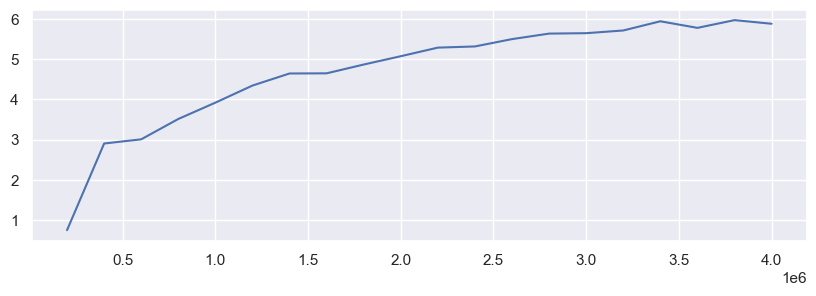

In [ ]:
training_stats = {}
for stats in experiment_agent.training_stats:
    training_stats["frame_stamp"] = training_stats.get("frame_stamp", []) + [stats["frame_stamp"]]
    training_stats["episode_rewards_mean"] = training_stats.get("episode_rewards_mean", []) + [stats["episode_rewards"]["mean"]]
    
# Plot the training stats
fig = plt.figure(figsize=(10, 3))
plt.plot(training_stats["frame_stamp"], training_stats["episode_rewards_mean"])
plt.show()

In [ ]:
# collect a set of states to check Q on before and after redo

eval_states = []

samples_nr = 100
skip_nr = 100
for i in range(samples_nr):
    for j in range(skip_nr):
        # get a random action from the environment
        action = experiment_agent.train_env.action_space.sample()
        s_prime, reward, is_terminated, truncated, info = experiment_agent.train_env.step(
            action
        )
        s_prime = torch.tensor(s_prime, device="cpu").float()

        if is_terminated:
            experiment_agent.train_env.reset()
            continue

    eval_states.append(s_prime)

In [ ]:
import copy

eval_states_tensor = torch.stack(eval_states)

predictions_init = experiment_agent.policy_model(eval_states_tensor)
predictions_init

max_q_vals_init = []
for state in eval_states_tensor:
    max_q_val = experiment_agent.get_max_q_val_for_state(state.unsqueeze(0))
    max_q_vals_init.append(max_q_val)

# get the weights before redo
state_dict_init = copy.deepcopy(experiment_agent.policy_model.state_dict())

In [ ]:
redo_scores = experiment_agent.policy_model.get_dormant_scores()
redo_scores

[tensor([0.0820, 0.0271, 0.0921, 0.0697, 0.0763, 0.1096, 0.0482, 0.0969, 0.0844,
         0.0458, 0.0899, 0.0372, 0.0459, 0.0604, 0.0323, 0.0022]),
 tensor([0.0669, 0.0781, 0.0536, 0.0777, 0.0489, 0.0639, 0.0867, 0.0468, 0.0376,
         0.0646, 0.0607, 0.0905, 0.0569, 0.0633, 0.0647, 0.0391]),
 tensor([0.0000, 0.0000, 0.0000, 0.0520, 0.0000, 0.0000, 0.0880, 0.0503, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0655, 0.0000, 0.0000, 0.0090, 0.0000, 0.0144,
         0.0000, 0.0000, 0.0014, 0.0609, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0479, 0.0443, 0.0750, 0.0610, 0.0065, 0.0620, 0.0165, 0.0000, 0.0000,
         0.0000, 0.0865, 0.0272, 0.0000, 0.0000, 0.0000, 0.0271, 0.0095, 0.0041,
         0.0226, 0.0195, 0.0534, 0.0030, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0505, 0.0207, 0.0000, 0.0000, 0.0000, 0.0076, 0.0000, 0.0000, 0.0000,
         0.0136])]

In [ ]:
sum([0.0000, 0.0000, 0.0000, 0.0520, 0.0000, 0.0000, 0.0880, 0.0503, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0655, 0.0000, 0.0000, 0.0090, 0.0000, 0.0144,
         0.0000, 0.0000, 0.0014, 0.0609, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0479, 0.0443, 0.0750, 0.0610, 0.0065, 0.0620, 0.0165, 0.0000, 0.0000,
         0.0000, 0.0865, 0.0272, 0.0000, 0.0000, 0.0000, 0.0271, 0.0095, 0.0041,
         0.0226, 0.0195, 0.0534, 0.0030, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0505, 0.0207, 0.0000, 0.0000, 0.0000, 0.0076, 0.0000, 0.0000, 0.0000,
         0.0136])

1.0

In [ ]:
# Reset % of neurons instead of hard threshold

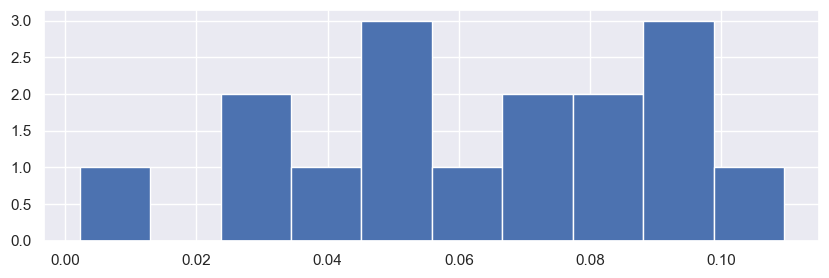

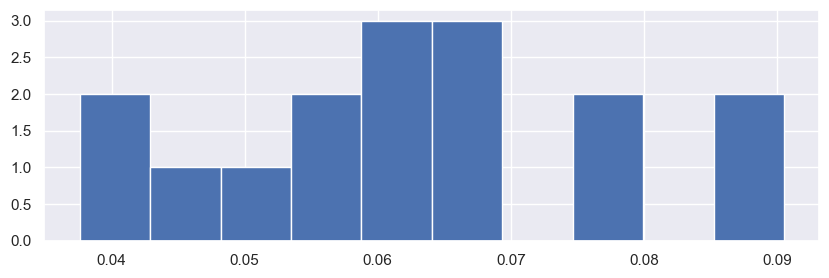

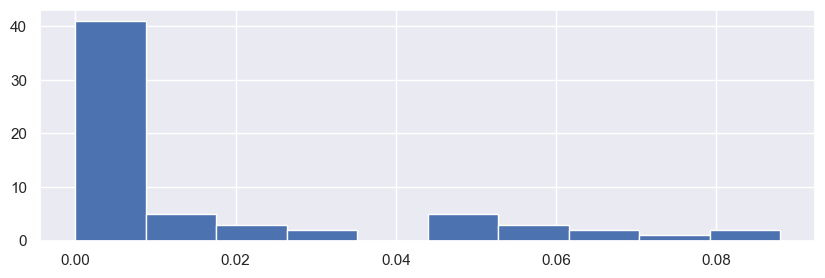

In [ ]:
# Histogram of redo_scores
for scores in redo_scores:
    fig = plt.figure(figsize=(10, 3))
    plt.hist(scores)
    plt.show()


In [ ]:
# apply redo
reset_details = experiment_agent.policy_model.apply_redo()
reset_details

[{'indexes': tensor([15]),
  'inbound': 'features.conv1',
  'outbound': 'features.conv2'},
 {'indexes': tensor([], dtype=torch.int64),
  'inbound': 'features.conv2',
  'outbound': 'fc.lin1'},
 {'indexes': tensor([ 0,  1,  2,  4,  5,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22,
          23, 24, 25, 26, 31, 33, 34, 35, 36, 39, 40, 41, 43, 44, 45, 46, 48, 49,
          50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
  'inbound': 'fc.lin1',
  'outbound': 'fc.lin2'}]

In [ ]:
layer_to_optim_idx = map_layers_to_optimizer_indices(
    experiment_agent.policy_model, experiment_agent.optimizer
)
layer_to_optim_idx

reset_optimizer_states(reset_details, experiment_agent.optimizer, layer_to_optim_idx)

In [ ]:
# get the difference between the values before and after
predictions_after = experiment_agent.policy_model(eval_states_tensor)
predictions_after

max_q_vals_after = []
for state in eval_states_tensor:
    max_q_val = experiment_agent.get_max_q_val_for_state(state.unsqueeze(0))
    max_q_vals_after.append(max_q_val)

# get the weights before redo
state_dict_after = experiment_agent.policy_model.state_dict()

In [ ]:
predictions_after

tensor([[-68.9132, -59.9846, -74.4019, -85.4608, -71.5550, -69.8788],
        [-71.9640, -64.6159, -78.7622, -87.1147, -76.5210, -69.7446],
        [-67.6195, -56.2639, -71.5551, -79.0819, -70.3180, -67.7702],
        [-72.4530, -64.4101, -78.2784, -87.9249, -77.2749, -71.2775],
        [-66.0585, -56.1860, -71.2668, -75.2160, -69.0242, -64.3309],
        [-67.6195, -56.2639, -71.5551, -79.0819, -70.3180, -67.7702],
        [-68.5480, -61.4907, -75.1733, -80.8267, -72.7027, -64.3455],
        [-67.6195, -56.2639, -71.5551, -79.0819, -70.3180, -67.7702],
        [-69.2651, -60.8314, -75.6256, -81.3423, -73.1285, -67.5707],
        [-64.5807, -54.3731, -66.7240, -82.6242, -66.4903, -61.3362],
        [-66.4287, -58.7100, -72.1625, -81.6561, -69.9134, -61.4031],
        [-63.9276, -53.8407, -67.9358, -75.4068, -65.9403, -61.4692],
        [-67.9622, -57.2824, -72.7117, -81.6774, -69.7870, -66.1789],
        [-60.8872, -56.0444, -67.0528, -73.9858, -64.5817, -59.1853],
        [-66.4287, -

In [ ]:
diff = np.array(max_q_vals_init) - np.array(max_q_vals_after)
sum(diff)

189.65997314453125

In [ ]:
max_q_vals_init

[-74.45775604248047,
 -55.29511642456055,
 -45.825992584228516,
 -51.62256622314453,
 -42.451316833496094,
 -45.825992584228516,
 -81.40369415283203,
 -45.825992584228516,
 -54.18619155883789,
 -46.212520599365234,
 -69.99578094482422,
 -41.16685104370117,
 -51.686275482177734,
 -65.84837341308594,
 -69.99578094482422,
 -46.420894622802734,
 -49.2805061340332,
 -45.825992584228516,
 -49.932945251464844,
 -50.58034133911133,
 -45.825992584228516,
 -68.43284606933594,
 -67.49866485595703,
 -56.525394439697266,
 -64.61248016357422,
 -56.525394439697266,
 -46.57208251953125,
 -46.753971099853516,
 -52.857269287109375,
 -46.420894622802734,
 -49.48026657104492,
 -67.53634643554688,
 -78.80984497070312,
 -46.832637786865234,
 -76.8270492553711,
 -61.8510627746582,
 -49.53068923950195,
 -49.53068923950195,
 -56.6690673828125,
 -50.3957633972168,
 -50.58034133911133,
 -50.9110221862793,
 -46.212520599365234,
 -66.85832977294922,
 -75.1754379272461,
 -63.531185150146484,
 -49.832332611083984,
 

In [ ]:
max_q_vals_after

[-59.98455810546875,
 -64.61592102050781,
 -56.26388168334961,
 -64.41006469726562,
 -56.18598556518555,
 -56.26388168334961,
 -61.4907112121582,
 -56.26388168334961,
 -60.83143997192383,
 -54.37312316894531,
 -58.709957122802734,
 -53.84073257446289,
 -57.282440185546875,
 -56.04440689086914,
 -58.709957122802734,
 -55.95698928833008,
 -61.107330322265625,
 -56.26388168334961,
 -59.006168365478516,
 -52.08506393432617,
 -56.26388168334961,
 -62.82534408569336,
 -64.787109375,
 -57.51601791381836,
 -61.455936431884766,
 -57.51601791381836,
 -59.15152359008789,
 -61.95449447631836,
 -55.10053634643555,
 -55.95698928833008,
 -59.07625198364258,
 -60.0987548828125,
 -63.14515686035156,
 -56.20692825317383,
 -58.47684097290039,
 -55.05485153198242,
 -63.112422943115234,
 -63.112422943115234,
 -60.74825668334961,
 -59.246055603027344,
 -52.08506393432617,
 -58.17887496948242,
 -54.37312316894531,
 -58.92610549926758,
 -61.775753021240234,
 -65.41036224365234,
 -59.307308197021484,
 -64.8657

In [ ]:
for layer in state_dict_after:
    if not torch.equal(state_dict_init[layer], state_dict_after[layer]):
        print(f"Weights changed in layer: {layer}")

Weights changed in layer: features.conv1.weight
Weights changed in layer: features.conv1.bias
Weights changed in layer: features.relu1.running_avg
Weights changed in layer: features.relu1.running_avg_cnt
Weights changed in layer: features.conv2.weight
Weights changed in layer: features.relu2.running_avg
Weights changed in layer: features.relu2.running_avg_cnt
Weights changed in layer: fc.lin1.weight
Weights changed in layer: fc.lin1.bias
Weights changed in layer: fc.relu3.running_avg
Weights changed in layer: fc.relu3.running_avg_cnt
Weights changed in layer: fc.lin2.weight


### Lightweight test